In [1]:
from fastai.conv_learner import *
from sklearn.metrics import fbeta_score

In [2]:
import warnings
warnings.filterwarnings('ignore')
def f2(pred, y):
    return max(fbeta_score(y, pred > threshold, 2, average="samples") for threshold in np.arange(0, 1, 0.01))

In [3]:
def f2_with_threshold(pred, y):
    return max((fbeta_score(y, pred > threshold, 2, average="samples"), threshold) for threshold in np.arange(0, 1, 0.01))

In [4]:
PATH = "data/"
sz = 224
bs = 10
arch = resnext50

In [5]:
df = pd.read_csv(f'{PATH}train_v2.csv')
df.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

In [6]:
val_idxs = get_cv_idxs(df.shape[0], val_pct=0.1)
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_csv(PATH, 'train-jpg', f'{PATH}train_v2.csv', bs=bs, tfms=tfms, val_idxs=val_idxs,
                                   test_name='test-jpg', suffix='.jpg')

In [7]:
data.resize(int(sz * 1.3))

In [8]:
learn = ConvLearner.pretrained(arch, data, metrics=[f2], ps=0.5)

 88%|█████████████████████████████████████     | 2856/3239 [06:19<00:50,  7.53it/s, loss=0.611]

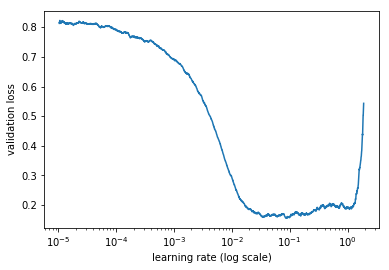

In [9]:
learn.lr_find()
learn.sched.plot()

In [10]:
lr = 1e-2

In [11]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   f2                                                            
    0      0.151454   0.121076   0.919053  
    1      0.135802   0.114457   0.924775                                                      
    2      0.138741   0.113286   0.923431                                                      


[array([0.11329]), 0.9234310430053871]

In [12]:
learn.unfreeze()
learn.bn_freeze(True)
learn.fit([lr/9, lr/3, lr], 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                                                            
    0      0.089314   0.088099   0.945344  
    1      0.090605   0.089653   0.944462                                                      
    2      0.094151   0.083018   0.949733                                                      
    3      0.090737   0.087511   0.945915                                                      
    4      0.093176   0.084614   0.946939                                                      
    5      0.082314   0.082254   0.94952                                                       
    6      0.085016   0.080848   0.95121                                                       


[array([0.08085]), 0.9512099050238005]

In [13]:
probs_tta, y = learn.TTA()
probs = np.mean(probs_tta, 0)

In [14]:
score, threshold = f2_with_threshold(probs, y)
score, threshold

(0.9313310096509697, 0.2)

In [ ]:
probs_tta, _ = learn.TTA(is_test=True)
probs = np.mean(probs_tta, 0)

In [22]:
df = pd.DataFrame(probs)
df.columns = data.classes
df.head()

agriculture  artisinal_mine  bare_ground  blooming  blow_down     clear  \
0     0.010811        0.000066     0.000573  0.088360   0.004796  0.999452   
1     0.965254        0.001053     0.034724  0.001154   0.003526  0.108003   
2     0.304290        0.000162     0.001383  0.000261   0.000111  0.062518   
3     0.357437        0.000212     0.014699  0.000762   0.000250  0.996723   
4     0.133376        0.000040     0.001930  0.012948   0.006850  0.999260   

     cloudy  conventional_mine  cultivation  habitation      haze  \
0  0.000250           0.000057     0.003989    0.002626  0.000300   
1  0.000985           0.001244     0.222636    0.091443  0.004548   
2  0.018528           0.000596     0.047328    0.016556  0.745813   
3  0.000122           0.000128     0.072034    0.009114  0.003581   
4  0.000110           0.000073     0.029332    0.003197  0.000457   

   partly_cloudy   primary      road  selective_logging  slash_burn     water  
0       0.000234  0.999765  0.002755           0.016975    0.000169  0.003854  
1       0.916513  0.985308  0.130330           0.001440    0.010752  0.023179  
2       0.012079  0.974180  0.919447           0.000891    0.000182  0.702587  
3       0.000666  0.999306  0.079806           0.000882    0.001375  0.951555  
4       0.000634  0.999807  0.003103           0.002796    0.000941  0.004341

In [23]:
tags = df.apply(lambda row: " ".join(tag for tag in row.index if row[tag] > threshold), axis=1)

In [24]:
submission = pd.DataFrame({'image_name': [x[9:-4] for x in data.test_ds.fnames], 'tags': tags})
submission.head()

image_name                                           tags
0     file_0                                  clear primary
1     file_1  agriculture cultivation partly_cloudy primary
2    file_10            agriculture haze primary road water
3   file_100                agriculture clear primary water
4  file_1000                                  clear primary

In [25]:
submission.to_csv('submission.csv', index=False)